# DistilBERT

# Task1

In [1]:
# !pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

C:\Users\earth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('2.16.1', '4.38.1', '2.1.2+cpu')

In [2]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


## 1. Loading our MNLI part of the GLUE dataset

In [3]:
import datasets

###1. Load Dataset
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

task_name = "mnli"
raw_datasets = datasets.load_dataset("glue", task_name)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [4]:
label_list = raw_datasets['train'].features['label'].names
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'entailment': 0, 'neutral': 1, 'contradiction': 2}

In [5]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'entailment', 1: 'neutral', 2: 'contradiction'}

## 2. Model & Tokenization

In [6]:
# Count the number of category
import numpy as np 
num_labels = np.unique(raw_datasets['train']['label']).size
num_labels

3

In [7]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)
# Create teacher model
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 3. Preprocessing 

In [8]:
# Create function to tokenize text
def tokenize_function(examples):
    sentence1_key, sentence2_key = task_to_keys[task_name] #task_name = "mnli"
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, max_length=128, truncation=True)
    return result

In [9]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [10]:
# list(task_to_keys[task_name])
column_dataset = [item for item in task_to_keys[task_name] if item is not None]
column_dataset

['premise', 'hypothesis']

In [11]:
#remove column : 'premise', 'hypothesis', 'idx'
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset + ["idx"])
#rename column : 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [12]:
tokenized_datasets['train'][0]['input_ids'] #.shape

tensor([  101, 17158,  2135,  6949,  8301, 25057,  2038,  2048,  3937,  9646,
         1011,  4031,  1998, 10505,  1012,   102,  4031,  1998, 10505,  2024,
         2054,  2191,  6949,  8301, 25057,  2147,  1012,   102])

In [13]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'[CLS] conceptually cream skimming has two basic dimensions - product and geography. [SEP] product and geography are what make cream skimming work. [SEP]'

## 4. Preparing the dataloader

In [14]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [15]:
# sample small dataset
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(10000))
small_eval_dataset = tokenized_datasets["validation_mismatched"].shuffle(seed=1150).select(range(1000))
small_test_dataset = tokenized_datasets["test_mismatched"].shuffle(seed=1150).select(range(1000))

In [16]:
# create dataloader
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [17]:
# check shape of batch
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 121]), torch.Size([32, 121]))

## 5. Design the model and losses

In [50]:
teacher_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "transformers_version": "4.38.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [51]:
# function to count trainable parameter
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [52]:
import torch.nn.functional as F

# function for calculate KL Loss
class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1): # temperature can set whatever you want
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [53]:
teacher_model = teacher_model.to(device)

In [54]:
from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

In [55]:
import numpy as np
import evaluate
# Get the metric function
if task_name is not None:
    metric = evaluate.load("glue", task_name)
else:
    metric = evaluate.load("accuracy")

### Model 1: Student model with top 6 layers

In [24]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration_model1 = teacher_model.config.to_dict()
# configuration

In [25]:
# Half the number of hidden layer
configuration_model1['num_hidden_layers'] //= 2

In [26]:
# Convert the dictionnary to the student configuration
configuration_model1 = BertConfig.from_dict(configuration_model1)

In [27]:
# Create uninitialized student model
model1 = type(teacher_model)(configuration_model1)
model1

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [28]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

# function to copy weight of teacher model
def distill_bert_weights_model1(
    teacher : Module,
    student : Module,
) -> None:
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights_model1(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers
        for i in range(len(student_encoding_layers)):
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i].state_dict()) #copy weight of first 6 layers of teacher model
    # Else the part is a head or something else, copy the state_dict (embedding,dropout)
    else:
        student.load_state_dict(teacher.state_dict())

    return model1

In [29]:
model1 = distill_bert_weights_model1(teacher=teacher_model, student=model1)

In [30]:
# print trainable parameter of teacher and student model
print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(model1))

Teacher parameters : 109484547
Student parameters : 66957315


In [31]:
count_parameters(model1)/count_parameters(teacher_model) * 100

61.15686353435797

In [32]:
criterion_div_model1 = DistillKL()
criterion_cos_model1 = nn.CosineEmbeddingLoss()

In [33]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer_model1 = optim.Adam(params=model1.parameters(), lr=lr)

In [34]:
model1 = model1.to(device)

In [35]:
lr_scheduler_model1 = get_scheduler(
    name="linear", 
    optimizer=optimizer_model1, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

In [36]:
# train model1
import torch
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0
best_loss = float('inf')

# Lists to store losses for each epoch
train_losses_model1 = []
train_losses_cls_model1 = []
train_losses_div_model1 = []
train_losses_cos_model1 = []
eval_losses_model1 = []

for epoch in range(num_epochs):
    model1.train()
    teacher_model.eval()
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = model1(**batch) 
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()
        
        # cls loss 
        loss_cls  = outputs.loss
        train_loss_cls += loss_cls.item()
        # distillation loss
        loss_div = criterion_div_model1(outputs.logits, output_teacher.logits)
        train_loss_div += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos_model1(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos += loss_cos.item()
        
        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3
        
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer_model1.step()
        lr_scheduler_model1.step()
        optimizer_model1.zero_grad()
        progress_bar.update(1)

        
    train_losses_model1.append(train_loss / len(train_dataloader))
    train_losses_cls_model1.append(train_loss_cls / len(train_dataloader))
    train_losses_div_model1.append(train_loss_div / len(train_dataloader))
    train_losses_cos_model1.append(train_loss_cos / len(train_dataloader))

    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model1.state_dict(), 'models/model1.pt')

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
    
    model1.eval()
    eval_loss = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model1(**batch)
            
        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    eval_losses_model1.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
    
    print(f"Epoch at {epoch+1}: Valid Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Validation Acc', eval_metrics/num_epochs)

 20%|██        | 313/1565 [15:52<50:04,  2.40s/it]  

Epoch at 1: Train loss 0.3505:
  - Loss_cls: 0.9497
  - Loss_div: 0.0529
  - Loss_cos: 0.0489
Epoch at 1: Valid Acc 0.6590


 40%|████      | 626/1565 [32:07<39:33,  2.53s/it]  

Epoch at 2: Train loss 0.3046:
  - Loss_cls: 0.7498
  - Loss_div: 0.1157
  - Loss_cos: 0.0484
Epoch at 2: Valid Acc 0.6700


 60%|██████    | 939/1565 [48:21<24:19,  2.33s/it]  

Epoch at 3: Train loss 0.2685:
  - Loss_cls: 0.5881
  - Loss_div: 0.1682
  - Loss_cos: 0.0492
Epoch at 3: Valid Acc 0.6670


 80%|████████  | 1252/1565 [1:04:24<11:34,  2.22s/it]

Epoch at 4: Train loss 0.2497:
  - Loss_cls: 0.5039
  - Loss_div: 0.1964
  - Loss_cos: 0.0489
Epoch at 4: Valid Acc 0.6740


100%|██████████| 1565/1565 [1:20:25<00:00,  2.48s/it]

Epoch at 5: Train loss 0.2430:
  - Loss_cls: 0.4750
  - Loss_div: 0.2053
  - Loss_cos: 0.0486
Epoch at 5: Valid Acc 0.6710
Avg Validation Acc 0.6682


### Model 2: Student model with bottom 6 layers

In [56]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration_model2 = teacher_model.config.to_dict()
# configuration

In [57]:
# Half the number of hidden layer
configuration_model2['num_hidden_layers'] //= 2

In [58]:
# Convert the dictionnary to the student configuration
configuration_model2 = BertConfig.from_dict(configuration_model2)

In [59]:
# Create uninitialized student model
model2 = type(teacher_model)(configuration_model2)
model2

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [60]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

# function to copy weight of teacher model
def distill_bert_weights_model2(
    teacher : Module,
    student : Module,
) -> None:
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights_model1(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers
        for i in range(len(student_encoding_layers)):
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[6+i].state_dict()) #copy weight of bottom 6 layers of teacher model
    # Else the part is a head or something else, copy the state_dict (embedding,dropout)
    else:
        student.load_state_dict(teacher.state_dict())

    return model2

In [61]:
model2 = distill_bert_weights_model1(teacher=teacher_model, student=model2)

In [62]:
print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(model2))

Teacher parameters : 109484547
Student parameters : 66957315


In [63]:
count_parameters(model2)/count_parameters(teacher_model) * 100

61.15686353435797

In [64]:
criterion_div_model2 = DistillKL()
criterion_cos_model2 = nn.CosineEmbeddingLoss()

In [65]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer_model2 = optim.Adam(params=model2.parameters(), lr=lr)

In [66]:
model2 = model2.to(device)

In [67]:
lr_scheduler_model2 = get_scheduler(
    name="linear", 
    optimizer=optimizer_model2, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

In [68]:
# train model2
import torch
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0
best_loss = float('inf')

# Lists to store losses for each epoch
train_losses_model2 = []
train_losses_cls_model2 = []
train_losses_div_model2 = []
train_losses_cos_model2 = []
eval_losses_model2 = []

for epoch in range(num_epochs):
    model2.train()
    teacher_model.eval()
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = model2(**batch) 
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()
        
        # cls loss 
        loss_cls  = outputs.loss
        train_loss_cls += loss_cls.item()
        # distillation loss
        loss_div = criterion_div_model2(outputs.logits, output_teacher.logits)
        train_loss_div += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos_model2(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos += loss_cos.item()
        
        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3
        
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer_model2.step()
        lr_scheduler_model2.step()
        optimizer_model2.zero_grad()
        progress_bar.update(1)

        
    train_losses_model2.append(train_loss / len(train_dataloader))
    train_losses_cls_model2.append(train_loss_cls / len(train_dataloader))
    train_losses_div_model2.append(train_loss_div / len(train_dataloader))
    train_losses_cos_model2.append(train_loss_cos / len(train_dataloader))

    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model2.state_dict(), 'models/model2.pt')

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
    
    model2.eval()
    eval_loss = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model2(**batch)
            
        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    eval_losses_model1.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
    
    print(f"Epoch at {epoch+1}: Valid Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Validation Acc', eval_metrics/num_epochs)

 20%|██        | 313/1565 [15:41<59:30,  2.85s/it]  

Epoch at 1: Train loss 0.2444:
  - Loss_cls: 0.4796
  - Loss_div: 0.2091
  - Loss_cos: 0.0446
Epoch at 1: Valid Acc 0.6670


 40%|████      | 626/1565 [32:50<36:51,  2.35s/it]  

Epoch at 2: Train loss 0.2382:
  - Loss_cls: 0.4601
  - Loss_div: 0.2147
  - Loss_cos: 0.0399
Epoch at 2: Valid Acc 0.6620


 60%|██████    | 939/1565 [49:05<26:01,  2.50s/it]  

Epoch at 3: Train loss 0.2324:
  - Loss_cls: 0.4388
  - Loss_div: 0.2215
  - Loss_cos: 0.0368
Epoch at 3: Valid Acc 0.6620


 80%|████████  | 1252/1565 [1:05:21<14:02,  2.69s/it]

Epoch at 4: Train loss 0.2299:
  - Loss_cls: 0.4335
  - Loss_div: 0.2231
  - Loss_cos: 0.0330
Epoch at 4: Valid Acc 0.6680


100%|██████████| 1565/1565 [1:21:37<00:00,  2.52s/it]

Epoch at 5: Train loss 0.2284:
  - Loss_cls: 0.4293
  - Loss_div: 0.2246
  - Loss_cos: 0.0314
Epoch at 5: Valid Acc 0.6700
Avg Validation Acc 0.6658000000000001


### Model 3: Student model with odd layers

In [69]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration_model3 = teacher_model.config.to_dict()
# configuration

In [70]:
# Half the number of hidden layer
configuration_model3['num_hidden_layers'] //= 2

In [71]:
# Convert the dictionnary to the student configuration
configuration_model3 = BertConfig.from_dict(configuration_model3)

In [72]:
# Create uninitialized student model
model3 = type(teacher_model)(configuration_model3)
model3

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [73]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

# function to copy weight of teacher model
def distill_bert_weights_model2(
    teacher : Module,
    student : Module,
) -> None:
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights_model1(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers
        for i in range(len(student_encoding_layers)):
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[(2*i)+1].state_dict()) #copy weight of odd layers of teacher model
    # Else the part is a head or something else, copy the state_dict (embedding,dropout)
    else:
        student.load_state_dict(teacher.state_dict())

    return model3

In [74]:
model3 = distill_bert_weights_model1(teacher=teacher_model, student=model3)

In [75]:
print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(model3))

Teacher parameters : 109484547
Student parameters : 66957315


In [76]:
count_parameters(model3)/count_parameters(teacher_model) * 100

61.15686353435797

In [77]:
criterion_div_model3 = DistillKL()
criterion_cos_model3 = nn.CosineEmbeddingLoss()

In [78]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer_model3 = optim.Adam(params=model3.parameters(), lr=lr)

In [79]:
model3 = model3.to(device)

In [80]:
lr_scheduler_model3 = get_scheduler(
    name="linear", 
    optimizer=optimizer_model3, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

In [81]:
# train model3
import torch
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0
best_loss = float('inf')

# Lists to store losses for each epoch
train_losses_model3 = []
train_losses_cls_model3 = []
train_losses_div_model3 = []
train_losses_cos_model3 = []
eval_losses_model3 = []

for epoch in range(num_epochs):
    model3.train()
    teacher_model.eval()
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = model3(**batch) 
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()
        
        # cls loss 
        loss_cls  = outputs.loss
        train_loss_cls += loss_cls.item()
        # distillation loss
        loss_div = criterion_div_model3(outputs.logits, output_teacher.logits)
        train_loss_div += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos_model3(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos += loss_cos.item()
        
        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3
        
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer_model3.step()
        lr_scheduler_model3.step()
        optimizer_model3.zero_grad()
        progress_bar.update(1)

        
    train_losses_model3.append(train_loss / len(train_dataloader))
    train_losses_cls_model3.append(train_loss_cls / len(train_dataloader))
    train_losses_div_model3.append(train_loss_div / len(train_dataloader))
    train_losses_cos_model3.append(train_loss_cos / len(train_dataloader))

    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model3.state_dict(), 'models/model3.pt')

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
    
    model3.eval()
    eval_loss = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model3(**batch)
            
        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    eval_losses_model1.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
    
    print(f"Epoch at {epoch+1}: Valid Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Validation Acc', eval_metrics/num_epochs)

100%|██████████| 1565/1565 [1:21:58<00:00,  3.14s/it]


Epoch at 1: Train loss 0.2327:
  - Loss_cls: 0.4458
  - Loss_div: 0.2208
  - Loss_cos: 0.0313
Epoch at 1: Valid Acc 0.6530


Epoch at 2: Train loss 0.2304:
  - Loss_cls: 0.4397
  - Loss_div: 0.2221
  - Loss_cos: 0.0293
Epoch at 2: Valid Acc 0.6490


Epoch at 3: Train loss 0.2277:
  - Loss_cls: 0.4312
  - Loss_div: 0.2242
  - Loss_cos: 0.0277
Epoch at 3: Valid Acc 0.6680


Epoch at 4: Train loss 0.2253:
  - Loss_cls: 0.4240
  - Loss_div: 0.2261
  - Loss_cos: 0.0258
Epoch at 4: Valid Acc 0.6530


Epoch at 5: Train loss 0.2242:
  - Loss_cls: 0.4203
  - Loss_div: 0.2273
  - Loss_cos: 0.0251
Epoch at 5: Valid Acc 0.6670
Avg Validation Acc 0.658


### Model 4: Student model with even layers

In [82]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration_model4 = teacher_model.config.to_dict()
# configuration

In [83]:
# Half the number of hidden layer
configuration_model4['num_hidden_layers'] //= 2

In [84]:
# Convert the dictionnary to the student configuration
configuration_model4 = BertConfig.from_dict(configuration_model4)

In [85]:
# Create uninitialized student model
model4 = type(teacher_model)(configuration_model4)
model4

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [86]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

# function to copy weight of teacher model
def distill_bert_weights_model2(
    teacher : Module,
    student : Module,
) -> None:
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights_model1(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers
        for i in range(len(student_encoding_layers)):
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2*i].state_dict()) #copy weight of even layers of teacher model
    # Else the part is a head or something else, copy the state_dict (embedding,dropout)
    else:
        student.load_state_dict(teacher.state_dict())

    return model4

In [87]:
model4 = distill_bert_weights_model1(teacher=teacher_model, student=model4)

In [88]:
print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(model4))

Teacher parameters : 109484547
Student parameters : 66957315


In [89]:
count_parameters(model4)/count_parameters(teacher_model) * 100

61.15686353435797

In [90]:
criterion_div_model4 = DistillKL()
criterion_cos_model4 = nn.CosineEmbeddingLoss()

In [91]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer_model4 = optim.Adam(params=model4.parameters(), lr=lr)

In [92]:
model4 = model4.to(device)

In [93]:
lr_scheduler_model4 = get_scheduler(
    name="linear", 
    optimizer=optimizer_model4, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

In [94]:
# train model4
import torch
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0
best_loss = float('inf')

# Lists to store losses for each epoch
train_losses_model4 = []
train_losses_cls_model4 = []
train_losses_div_model4 = []
train_losses_cos_model4 = []
eval_losses_model4 = []

for epoch in range(num_epochs):
    model4.train()
    teacher_model.eval()
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = model4(**batch) 
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()
        
        # cls loss 
        loss_cls  = outputs.loss
        train_loss_cls += loss_cls.item()
        # distillation loss
        loss_div = criterion_div_model4(outputs.logits, output_teacher.logits)
        train_loss_div += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos_model4(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos += loss_cos.item()
        
        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3
        
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer_model4.step()
        lr_scheduler_model4.step()
        optimizer_model4.zero_grad()
        progress_bar.update(1)

        
    train_losses_model4.append(train_loss / len(train_dataloader))
    train_losses_cls_model4.append(train_loss_cls / len(train_dataloader))
    train_losses_div_model4.append(train_loss_div / len(train_dataloader))
    train_losses_cos_model4.append(train_loss_cos / len(train_dataloader))

    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model4.state_dict(), 'models/model4.pt')

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
    
    model4.eval()
    eval_loss = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model4(**batch)
            
        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    eval_losses_model1.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
    
    print(f"Epoch at {epoch+1}: Valid Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Validation Acc', eval_metrics/num_epochs)

 20%|██        | 313/1565 [15:34<59:39,  2.86s/it]  

Epoch at 1: Train loss 0.2285:
  - Loss_cls: 0.4355
  - Loss_div: 0.2236
  - Loss_cos: 0.0263
Epoch at 1: Valid Acc 0.6510


 40%|████      | 626/1565 [31:36<39:44,  2.54s/it]  

Epoch at 2: Train loss 0.2271:
  - Loss_cls: 0.4326
  - Loss_div: 0.2236
  - Loss_cos: 0.0251
Epoch at 2: Valid Acc 0.6530


 60%|██████    | 939/1565 [47:29<29:15,  2.80s/it]  

Epoch at 3: Train loss 0.2250:
  - Loss_cls: 0.4252
  - Loss_div: 0.2255
  - Loss_cos: 0.0244
Epoch at 3: Valid Acc 0.6680


 80%|████████  | 1252/1565 [1:03:40<13:44,  2.63s/it]

Epoch at 4: Train loss 0.2234:
  - Loss_cls: 0.4192
  - Loss_div: 0.2274
  - Loss_cos: 0.0236
Epoch at 4: Valid Acc 0.6610


100%|██████████| 1565/1565 [1:19:43<00:00,  2.20s/it]

Epoch at 5: Train loss 0.2226:
  - Loss_cls: 0.4171
  - Loss_div: 0.2278
  - Loss_cos: 0.0228
Epoch at 5: Valid Acc 0.6660
Avg Validation Acc 0.6597999999999999


# Task2

Plot train and validation loss on each student model

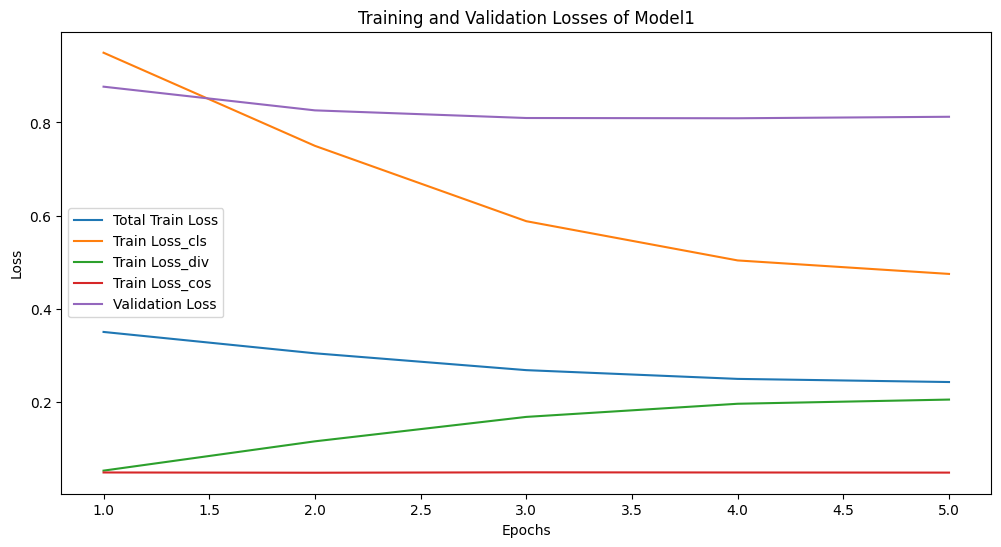

In [101]:
import matplotlib.pyplot as plt
# Plotting
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses_model1, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls_model1, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div_model1, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos_model1, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses_model1[:5], label='Validation Loss')

plt.title('Training and Validation Losses of Model1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

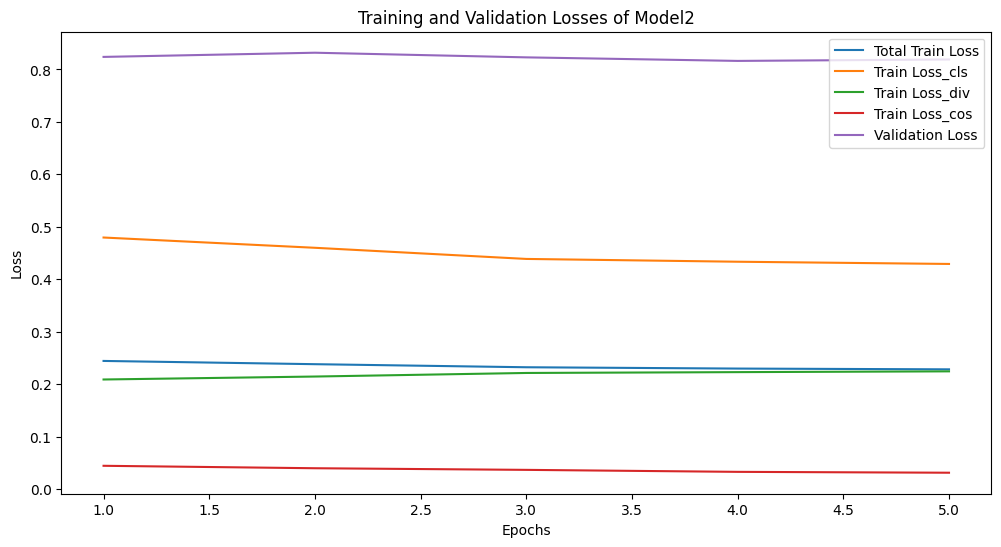

In [102]:
plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses_model2, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls_model2, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div_model2, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos_model2, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses_model1[5:10], label='Validation Loss')

plt.title('Training and Validation Losses of Model2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

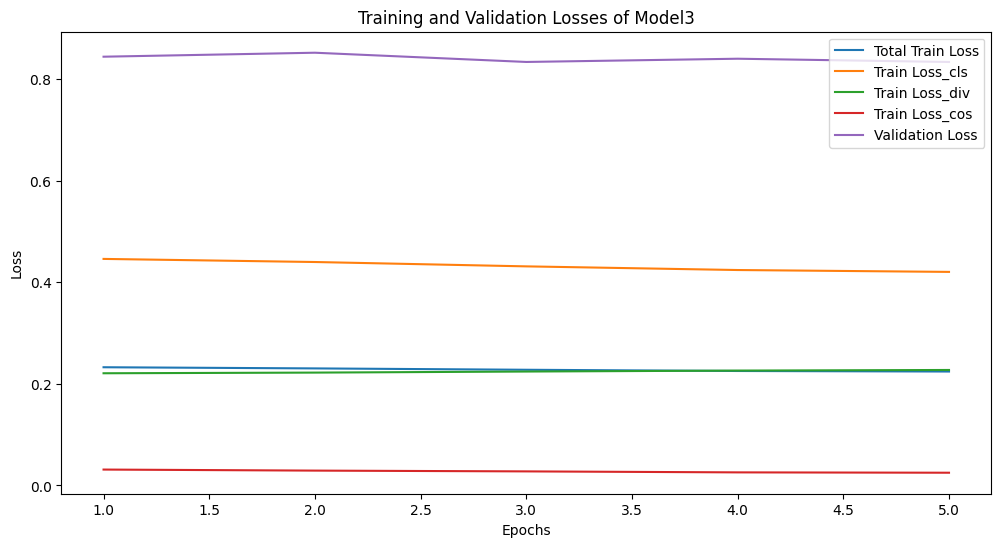

In [103]:
plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses_model3, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls_model3, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div_model3, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos_model3, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses_model1[10:15], label='Validation Loss')

plt.title('Training and Validation Losses of Model3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

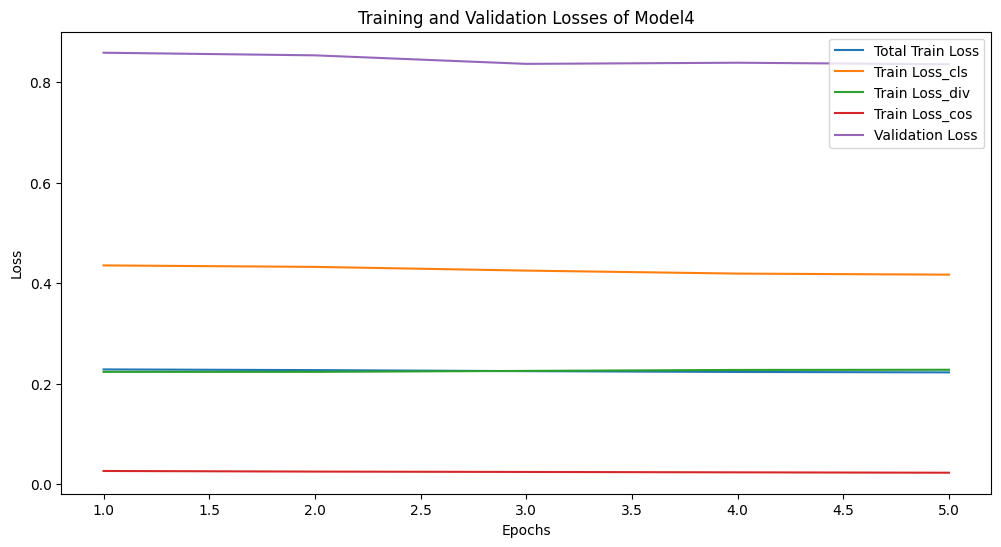

In [104]:
plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses_model4, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls_model4, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div_model4, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos_model4, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses_model1[15:], label='Validation Loss')

plt.title('Training and Validation Losses of Model4')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [110]:
# train teacher model

import torch
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn as nn

lr = 5e-5
#training hyperparameters
optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

progress_bar_teacher = tqdm(range(num_training_steps))
eval_metrics = 0

lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

for epoch in range(num_epochs):
    teacher_model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_teacher = teacher_model(**batch)
        # cls loss 
        loss = output_teacher.loss
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar_teacher.update(1)

    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(teacher_model.state_dict(), 'models/teacher_model.pt')

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    
    teacher_model.eval()
    for step, batch in enumerate(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = teacher_model(**batch)
    
        predictions = outputs.logits.argmax(dim=-1)
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    print(f"Epoch at {epoch+1}: Valid Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Valiadation Acc', eval_metrics/num_epochs)


  0%|          | 0/1565 [02:15<?, ?it/s]



























































































































































































































































































































Epoch at 1: Train loss 0.7820:
Epoch at 1: Valid Acc 0.7390


Epoch at 2: Train loss 0.4450:
Epoch at 2: Valid Acc 0.7440


Epoch at 3: Train loss 0.1802:
Epoch at 3: Valid Acc 0.7450


Epoch at 4: Train loss 0.0720:
Epoch at 4: Valid Acc 0.7500


Epoch at 5: Train loss 0.0353:
Epoch at 5: Valid Acc 0.7550
Avg Valiadation Acc 0.7466


| Student Layer | Trainable Loss @ last epoch (epoch 5) | Average Validation Accuracy | 
|:------------------------|:----------:|:----------:|
| model1: Top-K Layer |  0.2430  |  0.6682  | 
| model2: Bottom-K Layer |   0.2284  |  0.6658   |    
| model3: Odd Layer    |   0.2242   |   0.658   | 
| model4: Even Layer    |   0.2226     |   0.6598   | 
| Teacher Model | 0.0353 | 0.7466 |

From the performance table, I can conclude that the selection of layers for student model is effect the performance of student model.

Since my computer cannot use GPU and I has less time to do the assignment, I trained models with small dataset and small number of epoch. the student models are not good since the average validation accuracy of student is much lower than the accuracy of teacher model.  Therefore, I can improve my model in the future by increase the train dataset and increase train epoch